## **Strategy** 
One way to improve the performance of the basic strategy is to allow collaboration between agents during the transmission phase.    

The search phase is the same as for the basic strategy, all agents move randomly in search of the target. 

But now in this improved strategy, the first robot that finds the target moves towards the command center while checking if there is an agent within transmission range that is closer to the command centre than he is. If such an agent exists, the responsibility for transmitting the target's position becomes his. If an agent is within communication range but is further from the command center, there's no point in considering him a relay. In this new strategy, it is possible to have up to two relays during the transmission phase.


## **Performance**

The performance of this strategy was also evaluated in terms of the number of steps needed to find the target and the number of steps needed to report the target’s position to the command center. Monte Carlo simulation with 10 000 scenarios have been carried out to get an idea of how this strategy performs. At the beginning of each scenario, the agents and the target are randomly placed on the grid.     

Each scenario ends when the agent who is responsible for transmitting the target’s position (the last relay or the agent that finds the target first if he didn’t find relays on his trajectory) gets within communication range of the command center.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import stats
from collections import Counter

## **Exogenous Parameters**

In [2]:
detection_range = 2
transmission_range = 5
num_robots = 5

## **Initial Configuration**

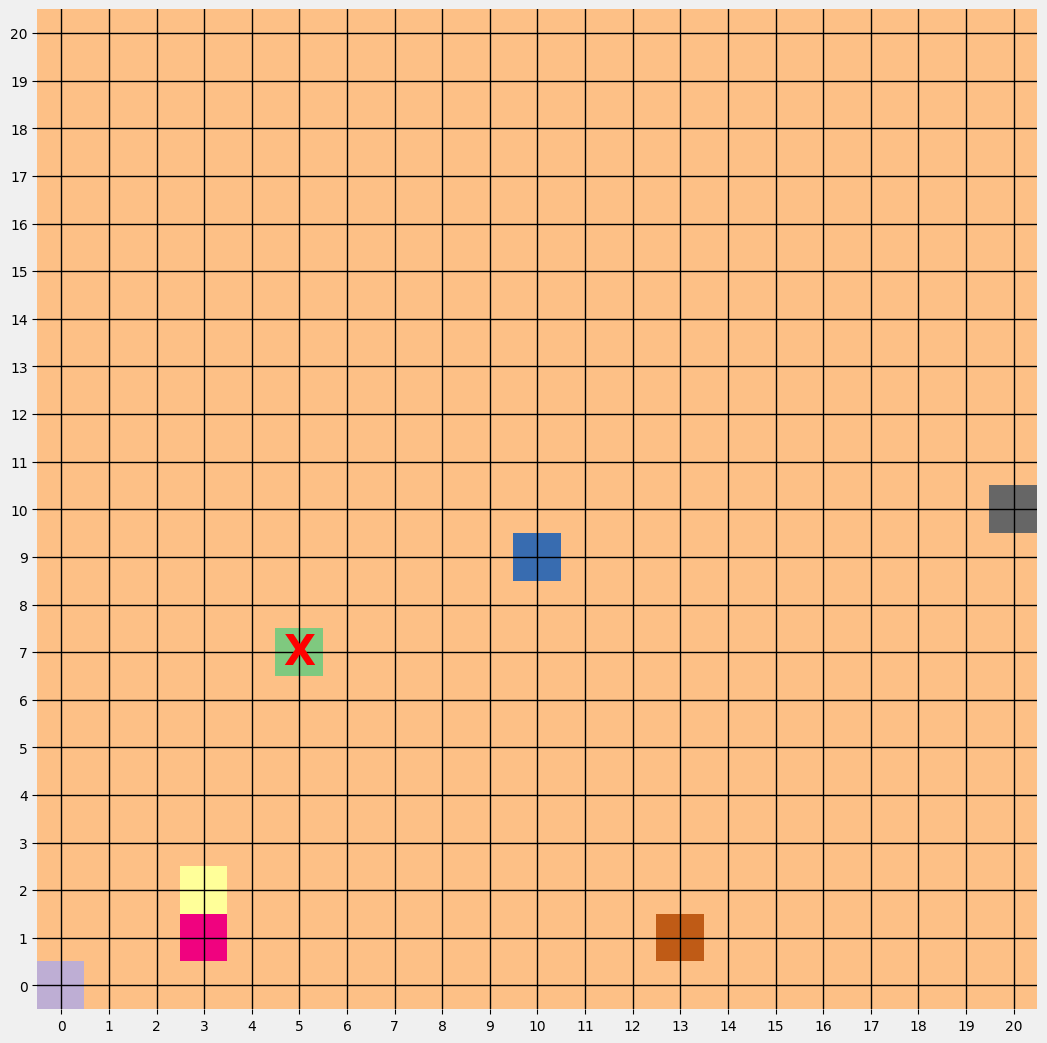

In [3]:
def place_robots(num_robots, specified_positions=None, grid_size=(21, 21)):
    
    grid = np.full(grid_size, None, dtype=object)

    # Command center at (0,0)
    grid[0, 0] = -1  # Command center is identified as -1 on the numeric grid

    
    # Unless initial positions are specified for the robots, they will be randomly generated 
    if specified_positions is not None and len(specified_positions) == num_robots:
        robot_positions = specified_positions
    else:
        # List of all unique positions on the grid
        all_positions = np.array(np.meshgrid(range(1, grid_size[0]), range(1, grid_size[1]))).T.reshape(-1, 2)
        
        # Random selection of the robots initial positions
        robot_positions = all_positions[np.random.choice(len(all_positions), size=num_robots, replace=False)]
        

    robot_names = np.arange(1, num_robots + 1)

    
    
    for position, name in zip(robot_positions, robot_names):
        grid[position[0], position[1]] = name

        
    # Generating a random position for the target
    while True:
        red_cross_position = np.random.choice(range(1, grid_size[0]), size=2)
        if grid[red_cross_position[0], red_cross_position[1]] is None:
            break


    grid_numeric = np.zeros_like(grid, dtype=int)
    grid_numeric[grid == -1] = -1  

    
    for i in range(1, num_robots + 1):
        grid_numeric[grid == i] = i

    
    grid_numeric[red_cross_position[0], red_cross_position[1]] = -2

    return grid_numeric, red_cross_position, grid_size

  
    
specified_positions = []

    
grid_result, red_cross_position, grid_size = place_robots(num_robots, specified_positions, grid_size=(21, 21))



# Displaying initial condiguration on a grid
fig = plt.figure(figsize=(10, 10), facecolor='#f0f0f0')

# Add axes to the new figure
ax = fig.add_axes([0, 0, 1, 1])
# Display the grid result with a specified colormap and extent
cax = ax.imshow(grid_result, cmap='Accent', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])
# Hide the axes spines
ax.set_frame_on(False)

# Add grid lines for better visualization (optional)
plt.grid(True, which='both', color='black', linewidth=1)

# Set axis ticks and labels in the center of squares
plt.xticks(np.arange(0.5, grid_size[0] + 0.5, 1), np.arange(0, grid_size[0], 1))
plt.yticks(np.arange(0.5, grid_size[1] + 0.5, 1), np.arange(0, grid_size[1], 1))

ax.text(red_cross_position[1] + 0.5, red_cross_position[0] + 0.5, 'X', fontsize=30, color='r', ha='center', va='center', fontweight='bold')

# Show the plot in a pop-up window
plt.show(block=True)

In [4]:
pos_init = []
for robot in range(1, num_robots + 1):
    pos_init.append(np.argwhere(grid_result == robot)[0])

current_positions = [pos_init[robot][::-1] for robot in range(num_robots)]
current_positions

[array([3, 2]),
 array([10,  9]),
 array([3, 1]),
 array([13,  1]),
 array([20, 10])]

## **Search Phase**

Occupied positions = {(13, 1), (3, 1), (5, 7), (20, 10), (10, 9), (3, 2)}
Time Step =  1


Occupied positions = {(13, 1), (3, 1), (5, 7), (20, 10), (10, 9), (3, 2)}


Robot =  1
Current position =  [3 2]
['up', 'left', 'right', 'up left', 'up right', 'down left', 'down right']
New position =  [2 1]
Occupied positions = {(2, 1), (13, 1), (3, 1), (5, 7), (20, 10), (10, 9)}


Robot =  2
Current position =  [10  9]
['up', 'down', 'left', 'right', 'up left', 'up right', 'down left', 'down right']
New position =  [11  9]
Occupied positions = {(2, 1), (13, 1), (3, 1), (11, 9), (5, 7), (20, 10)}


Robot =  3
Current position =  [3 1]
['up', 'right', 'up left', 'up right']
New position =  [3 2]
Occupied positions = {(2, 1), (13, 1), (11, 9), (5, 7), (20, 10), (3, 2)}


Robot =  4
Current position =  [13  1]
['up', 'left', 'right', 'up left', 'up right']
New position =  [12  1]
Occupied positions = {(12, 1), (2, 1), (11, 9), (5, 7), (20, 10), (3, 2)}


Robot =  5
Current position =  [20 10]
['up

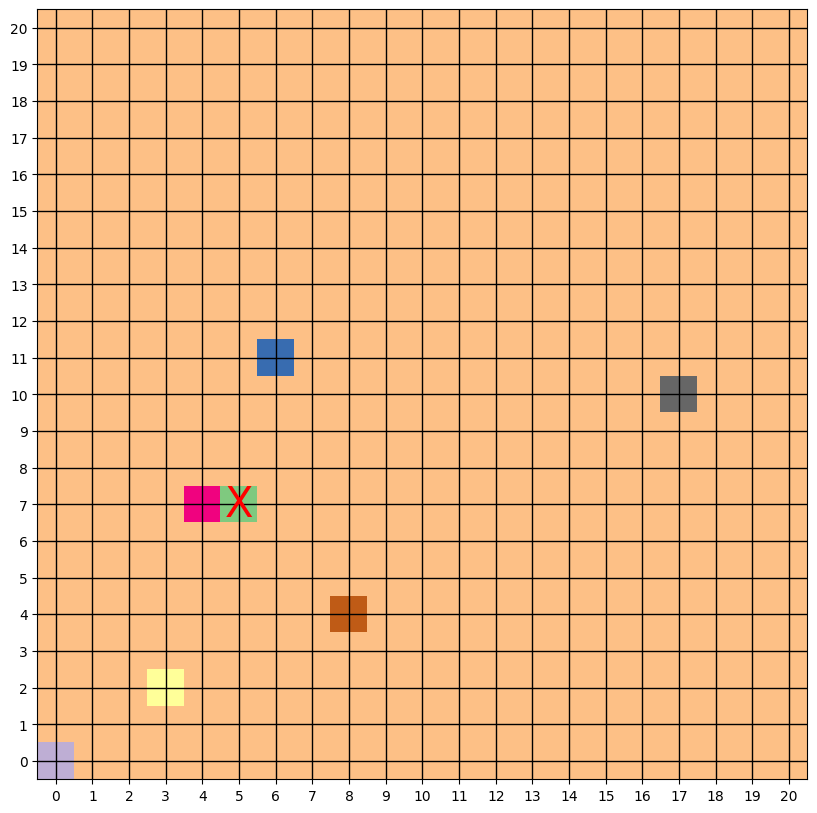

In [5]:
directions = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0), 'up left': (-1, 1), 'up right': (1, 1), 'down left': (-1, -1), 'down right': (1, -1)}
moves = ["up", "down", "left", "right", "up left", "up right", "down left", "down right"]



# At each time step, each agent evaluate all possible valid actions it can take (while staying within the grid and avoiding collisions) 
# Then, a random one is chosen from among those available
def get_possible_moves(pos, grid_size, occupied_positions):
    max_x, max_y = grid_size
    x, y = pos
    possible_moves = []

    for move in moves:
        new_x, new_y = x + directions[move][0], y + directions[move][1]
        if 1 <= new_x < max_x and 1 <= new_y < max_y :
            if not any(np.array_equal(pair, (new_x, new_y)) for pair in occupied_positions) :
                possible_moves.append(move)

    return possible_moves



# Keeping track of the occupied collisions to ease collisions gestion
occupied_positions = {tuple(pair) for pair in current_positions}
occupied_positions.add(tuple(red_cross_position[::-1]))
print("Occupied positions =", occupied_positions)



t = 0
target_reached = False

while not target_reached :
    
    t += 1
    
    new_positions = []
    
    found_by = np.zeros(num_robots)
    
    print("Time Step = ", t)
    print("\n")
    print("Occupied positions =", occupied_positions)
    print("\n")

    
    for robot in range(num_robots):
        print("Robot = ", robot + 1)

        current_pos = current_positions[robot]
        print("Current position = ", current_pos)

        move_choices = get_possible_moves(current_pos, grid_size, occupied_positions)
        print(move_choices)


        # If the robot is able to move safely
        if move_choices:

            new_position = tuple(np.add(current_pos, directions[random.choice(move_choices)]))

            new_positions.append(np.array(new_position))

            current_positions[robot] = np.array(new_position)
            
            grid_result[current_pos[1], current_pos[0]] = 0
            grid_result[new_positions[robot][1], new_positions[robot][0]] = robot + 1

            print("New position = ", new_positions[robot])

            occupied_positions.remove(tuple(current_pos))

            occupied_positions.add(new_position)

            print("Occupied positions =", occupied_positions)
            print("\n")

        # If the robot is not able to move safely, it stays on the same spot
        else:

            new_positions.append(current_pos)
            current_positions[robot] = current_pos
            print("New positions =", current_positions)
            print("Occupied positions =", occupied_positions)
            print("\n")
            
            
    # Is there an agent within detection range of the target ? 
    for robot in range(num_robots):
        if math.sqrt((new_positions[robot][0] - red_cross_position[1]) ** 2 + (new_positions[robot][1] - red_cross_position[0]) ** 2) <= detection_range:
            target_reached = True
            found_by[robot] = 1
            print("Found by robot {} : {} ".format(robot + 1, found_by[robot]))
            print("\n") 


        else:
            found_by[robot] = 0
            print("Found by robot {} : {} ".format(robot + 1, found_by[robot]))
            print("\n") 
            



found_by_ar = np.array(found_by)
non_null_position = np.nonzero(found_by_ar)[0][0]
target_perimeter = new_positions[non_null_position]
print("Target perimeter = ", target_perimeter)
print("\n") 


# Display the numerical version of the updated grid
print("Updated grid:")
print(grid_result)
print("\n") 
print("\n")



fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(grid_result, cmap='Accent', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])


# Add grid lines for better visualization (optional)
plt.grid(True, which='both', color='black', linewidth=1)


# Set axis ticks and labels in the center of squares
plt.xticks(np.arange(0.5, grid_size[0] + 0.5, 1), np.arange(0, grid_size[0], 1))
plt.yticks(np.arange(0.5, grid_size[1] + 0.5, 1), np.arange(0, grid_size[1], 1))



# Display the red cross on the plot
plt.text(red_cross_position[1] + 0.5, red_cross_position[0] + 0.5, 'X', fontsize=30, color='r', ha='center', va='center')

# Show the plot in a pop-up window
plt.show(block=True)

In [6]:
current_positions2 = new_positions
current_positions2

[array([3, 2]), array([ 6, 11]), array([4, 7]), array([8, 4]), array([17, 10])]

## **Transmission Phase**

In [7]:
CC_reached = False

print("Occupied positions = ", occupied_positions)
print("\n")


# Is the robot that found the target within transmission range of the CC ??
if (math.sqrt((current_positions2[non_null_position][0] - 0) ** 2 + (current_positions2[non_null_position][1] - 0) ** 2) <= transmission_range):
    CC_reached = True
    print("Robot {} is within transmission range of the command center".format(non_null_position + 1))
    print("\n")
    
else : 
    print("Robot {} is not within transmission range of the command center".format(non_null_position + 1))
    print("\n")
    
    


    
prox = np.zeros(num_robots)
exit = False

if CC_reached == False:

    for robot in range(num_robots):

        # Is there a robot close to the robot that found the target and that is closer to the command center ? 
        if 0 < (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) <= transmission_range :

            prox[robot] = 1
            print("Robot {} is within transmission range of robot {} ".format(robot + 1, non_null_position + 1))


        elif (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2  + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) == 0 : 
            prox[robot] = None 

        else : 
            prox[robot] = 0
            print("Robot {} is not within transmission range of robot {} ".format(robot + 1, non_null_position + 1))


    ind = np.where(np.array(prox) == 1)[0]



    if len(ind) == 0 :
        print("There is no robot within transmission range to robot {} ".format(non_null_position + 1))
        print("\n")

    else : 
        dist_to_CC = np.zeros(num_robots)
        
        cand = []

    
        for robot in range(num_robots) :

            if robot in ind : 

                dist_to_CC[robot] = math.sqrt( (current_positions2[robot][0] - 0)**2 + (current_positions2[robot][1] - 0)**2 )

                if 0 < dist_to_CC[robot] <= transmission_range : 
                    CC_reached = True
                    print("Robot {} is within transmission range of robot {} and the command center".format(robot + 1, non_null_position + 1))


                if (dist_to_CC[robot] > transmission_range) and (dist_to_CC[robot] < math.sqrt( (current_positions2[non_null_position][0] - 0)**2 + 
                                                                                               (current_positions2[non_null_position ][1] - 0)**2 ) ): 
                    cand.append(robot)
                    print("Robot {} is within transmission range of robot {} and is closer to the command center".format(robot + 1, non_null_position + 1))

            else : 
                dist_to_CC[robot] = 10000
                print("Robot {} is not closer to the command center than robot {} ".format(robot + 1, non_null_position + 1))



        if CC_reached == True : 
            exit = True

        if not exit : 
            if len(cand) == 0 : 
                print("There is no robot whithin transmission range of robot {} and that is closer to the CC".format(non_null_position + 1))
                print("\n")

            else : 

                relay1 = None
                relay1 = np.argmin(dist_to_CC)

                print("Robot {} is the first relay".format(relay1 + 1))
                print("Current position of the Relay 1 : ", current_positions2[relay1])


                # Is there a direct 2nd relay ?
                potential_direct_2nd_relay = []
                potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                              0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                              np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                if len(potential_direct_2nd_relay) != 0 :  
                    direct_relay2 = None
                    direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                    CC_reached = True
                    print("Robot {} which is at position {} is the direct second relay. Target position has been transmitted".format(direct_relay2 + 1, 
                                                                                                                                  current_positions2[direct_relay2]))
                    print("\n")

                else : 
                    print("There is not a direct second relay in the sector")
                    print("\n")


                    # Is there an indirect 2nd relay
                    potential_indirect_2nd_relay = []
                    potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                    0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                    np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                    # Indirect 2nd relay in the sector
                    if len(potential_indirect_2nd_relay) != 0 :
                        indirect_relay2 = None
                        indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                        print("Robot {} is the indirect relay 2. He has to move".format(indirect_relay2 + 1))
                        print("\n")


                        p_relay2 = 0

                        while not CC_reached : 

                            p_relay2 += 1
                            new_positions2 = []
                            sent_by = np.zeros(num_robots)
                            print("Step (indirect relay2) = ", p_relay2)
                            print("\n")


                            for robot in range(num_robots):

                                print("Robot = ", robot + 1)

                                current_pos2 = None
                                current_pos2 = current_positions2[robot]
                                print("Current position = ", current_pos2)

                                if robot == indirect_relay2 :

                                    best_move_found = False

                                    len_to_CC = []
                                    len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                    sorted_moves = None
                                    sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                    move = None
                                    for move in sorted_moves : 

                                        new_position2 = None
                                        new_position2 = tuple(np.add(current_pos2, directions[move]))

                                        if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                            new_positions2.append(np.array(new_position2))
                                            current_positions2[robot] = np.array(new_position2)

                                            best_move_found = True

                                            print("New position = ", new_position2)

                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                            grid_result[new_position2[1], new_position2[0]] = robot + 1

                                            occupied_positions.remove(tuple(current_pos2))
                                            occupied_positions.add(new_position2)

                                            print("Occupied positions = ", occupied_positions)
                                            print("\n")

                                            break

                                    if not best_move_found : 

                                        current_positions2[robot] = current_pos2
                                        new_positions2.append(current_pos2)
                                        print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                        print("New position = ", new_positions2[robot])



                                else : 

                                    move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                    if move_choices :
                                        new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                        new_positions2.append(np.array(new_position2))
                                        print("New position = ", new_position2)

                                        current_positions2[robot] = np.array(new_position2)

                                        grid_result[current_pos2[1], current_pos2[0]] = 0
                                        grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                        occupied_positions.remove(tuple(current_pos2))
                                        occupied_positions.add(new_position2)
                                        print("Occupied positions = ", occupied_positions)
                                        print("\n")

                                    else:

                                        new_positions2.append(current_pos2)
                                        current_positions2[robot] = current_pos2
                                        print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                        print("New position = ", new_position2)
                                        print("\n")



                            if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                sent_by[indirect_relay2] = 1
                                CC_reached = True
                                print("Robot (indirect relay2) {} is now within transmission range of the command center".format(indirect_relay2 + 1))
                                print("\n")

                            else:
                                sent_by[indirect_relay2] = 0
                                print("Robot {} is still not within transmission range of the command center".format(indirect_relay2 + 1)) 
                                print("\n")


                    # No indirect 2nd relay in the sector
                    else : 
                        print("There is not an indirect 2nd relay in the sector. Robot {} (relay1) has to move ".format(relay1 + 1))
                        print("\n")


                        p_relay1 = 0

                        while not CC_reached : 

                            p_relay1 += 1
                            new_positions2 = []
                            sent_by = np.zeros(num_robots)
                            print("Step relay1 = ", p_relay1)
                            print("\n")


                            for robot in range(num_robots):

                                print("Robot = ", robot + 1)

                                current_pos2 = None
                                current_pos2 = current_positions2[robot]
                                print("Current position = ", current_pos2)

                                if robot == relay1 :

                                    best_move_found = False

                                    len_to_CC = []
                                    len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                    sorted_moves = None
                                    sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                    move = None
                                    for move in sorted_moves : 

                                        new_position2 = None
                                        new_position2 = tuple(np.add(current_pos2, directions[move]))

                                        if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                            new_positions2.append(np.array(new_position2))
                                            current_positions2[robot] = np.array(new_position2)

                                            best_move_found = True

                                            print("New position = ", new_position2)

                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                            grid_result[new_position2[1], new_position2[0]] = robot + 1

                                            occupied_positions.remove(tuple(current_pos2))
                                            occupied_positions.add(new_position2)

                                            print("Occupied positions = ", occupied_positions)
                                            print("\n")

                                            break

                                    if not best_move_found : 

                                        current_positions2[robot] = current_pos2
                                        new_positions2.append(current_pos2)
                                        print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                        print("New position = ", new_positions2[robot])
                                        print("\n")



                                else : 

                                    move_choices = None
                                    move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                    if move_choices :
                                        new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                        new_positions2.append(np.array(new_position2))
                                        print("New position = ", new_position2)

                                        current_positions2[robot] = np.array(new_position2)

                                        grid_result[current_pos2[1], current_pos2[0]] = 0
                                        grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                        occupied_positions.remove(tuple(current_pos2))
                                        occupied_positions.add(new_position2)
                                        print("Occupied positions = ", occupied_positions)
                                        print("\n")

                                    else:

                                        new_positions2.append(current_pos2)
                                        current_positions2[robot] = current_pos2
                                        print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                        print("New position = ", new_position2)
                                        print("\n")



                            if (math.sqrt((new_positions2[relay1][0] - 0) ** 2 + (new_positions2[relay1][1] - 0) ** 2) <= transmission_range):
                                sent_by[relay1] = 1
                                CC_reached = True
                                print("Robot (relay1) {} is now within transmission range of the command center".format(relay1 + 1))

                            else:
                                sent_by[relay1] = 0
                                print("Robot {} is still not within transmission range of the command center".format(relay1 + 1))
                                print("\n")


                                # Is there a direct 2nd relay ?
                                potential_direct_2nd_relay = []
                                potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                              0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                              np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                                if len(potential_direct_2nd_relay) != 0 :  
                                    direct_relay2 = None
                                    direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                                    CC_reached = True
                                    print("Robot {} which is at position {} is the direct second relay. Target position has been transmitted".format(direct_relay2 + 1, 
                                                                                                                                                  current_positions2[direct_relay2]))
                                    print("\n")

                                else : 
                                    print("There is not a direct second relay in the sector")
                                    print("\n")


                                    # Is there an indirect 2nd relay
                                    potential_indirect_2nd_relay = []
                                    potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                    0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                    np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                                    # Indirect 2nd relay in the sector
                                    if len(potential_indirect_2nd_relay) != 0 :
                                        indirect_relay2 = None
                                        indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                                        print("Robot {} is the indirect relay 2. He has to move".format(indirect_relay2 + 1))
                                        print("\n")

                                        p_relay2 = 0


                                        while not CC_reached : 

                                            p_relay2 += 1
                                            new_positions2 = []
                                            sent_by = np.zeros(num_robots)
                                            print("Step (indirect relay2) = ", p_relay2)
                                            print("\n")


                                            for robot in range(num_robots):

                                                print("Robot = ", robot + 1)

                                                current_pos2 = None
                                                current_pos2 = current_positions2[robot]
                                                print("Current position = ", current_pos2)

                                                if robot == indirect_relay2 :

                                                    best_move_found = False

                                                    len_to_CC = []
                                                    len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                                    sorted_moves = None
                                                    sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                                    move = None
                                                    for move in sorted_moves : 

                                                        new_position2 = None
                                                        new_position2 = tuple(np.add(current_pos2, directions[move]))

                                                        if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                            new_positions2.append(np.array(new_position2))
                                                            current_positions2[robot] = np.array(new_position2)

                                                            best_move_found = True

                                                            print("New position = ", new_position2)

                                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                                            grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                            occupied_positions.remove(tuple(current_pos2))
                                                            occupied_positions.add(new_position2)

                                                            print("Occupied positions = ", occupied_positions)
                                                            print("\n")

                                                            break

                                                    if not best_move_found : 

                                                        current_positions2[robot] = current_pos2
                                                        new_positions2.append(current_pos2)
                                                        print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                                        print("New position = ", new_positions2[robot])



                                                else : 

                                                    move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                                    if move_choices :
                                                        new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                                        new_positions2.append(np.array(new_position2))
                                                        print("New position = ", new_position2)

                                                        current_positions2[robot] = np.array(new_position2)

                                                        grid_result[current_pos2[1], current_pos2[0]] = 0
                                                        grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                                        occupied_positions.remove(tuple(current_pos2))
                                                        occupied_positions.add(new_position2)
                                                        print("Occupied positions = ", occupied_positions)
                                                        print("\n")

                                                    else:

                                                        new_positions2.append(current_pos2)
                                                        current_positions2[robot] = current_pos2
                                                        print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                                        print("New position = ", new_position2)



                                            if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                                sent_by[indirect_relay2] = 1
                                                CC_reached = True
                                                print("Robot (indirect relay2) {} is now within transmission range of the command center".format(indirect_relay2 + 1))

                                            else:
                                                sent_by[indirect_relay2] = 0
                                                print("Robot {} is still not within transmission range of the command center".format(indirect_relay2 + 1)) 



                                    else :
                                        print("Robot {} is not within transmission range to the CC and has not yet found a 2nd relay".format(relay1+1))


            
            
k = 0  

exit2 = False
while not CC_reached : 
    
    print("Robot {} needs to move to relay target's position".format(non_null_position + 1))
    print("\n")
    
    new_positions2 = []
    sent_by = np.zeros(num_robots)
    k += 1
    print("Time step (non_null_position) = " , k)
    print("\n")

    for robot in range(num_robots):
        print("Robot = ", robot + 1)
        
        
        current_pos2 = None
        current_pos2 = current_positions2[robot]
        print("Current position = ", current_pos2)

        if robot == non_null_position :

            best_move_found = False

            len_to_CC = []
            len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


            sorted_moves = None
            sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


            move = None
            for move in sorted_moves : 

                new_position2 = None
                new_position2 = tuple(np.add(current_pos2, directions[move]))

                if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                    new_positions2.append(np.array(new_position2))
                    current_positions2[robot] = np.array(new_position2)

                    best_move_found = True

                    print("New position = ", new_position2)

                    grid_result[current_pos2[1], current_pos2[0]] = 0
                    grid_result[new_position2[1], new_position2[0]] = robot + 1

                    occupied_positions.remove(tuple(current_pos2))
                    occupied_positions.add(new_position2)

                    print("Occupied positions = ", occupied_positions)
                    print("\n")

                    break

            if not best_move_found : 

                current_positions2[robot] = current_pos2
                new_positions2.append(current_pos2)
                print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                print("New position = ", new_positions2[robot])



        else : 

            move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

            if move_choices :
                new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                new_positions2.append(np.array(new_position2))
                print("New position = ", new_position2)

                current_positions2[robot] = np.array(new_position2)

                grid_result[current_pos2[1], current_pos2[0]] = 0
                grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                occupied_positions.remove(tuple(current_pos2))
                occupied_positions.add(new_position2)
                print("Occupied positions = ", occupied_positions)
                print("\n")

            else:

                new_positions2.append(current_pos2)
                current_positions2[robot] = current_pos2
                print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                print("New position = ", new_position2)
      
    
    if (math.sqrt((new_positions2[non_null_position][0] - 0) ** 2 + (new_positions2[non_null_position][0] - 0) ** 2) <= transmission_range) : 
        CC_reached = True
        print("Robot {} is now within range of the command center".format(non_null_position + 1))
        break
    else : 
        print("Robot {} is still not within range of the command center".format(non_null_position + 1))
        
    
    prox = np.zeros(num_robots)

    if CC_reached == False:

        for robot in range(num_robots):

            # Is there a robot close to the robot that found the target and that is closer to the command center ? 
            if 0 < (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 
                                    + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) <= transmission_range :

                prox[robot] = 1
                print("Robot {} is within transmission range of robot {} ".format(robot + 1, non_null_position + 1))


            elif (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 
                                    + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) == 0 : 
                prox[robot] = None 

            else : 
                prox[robot] = 0
                print("Robot {} is not within transmission range of robot {} ".format(robot + 1, non_null_position + 1))


        ind = np.where(np.array(prox) == 1)[0]



        if len(ind) == 0 :
            print("There is no robot within transmission range to robot {} ".format(non_null_position + 1))
            print("\n")
            
            
        else : 
            dist_to_CC = np.zeros(num_robots)

            cand = []


            for robot in range(num_robots) :

                if robot in ind : 

                    dist_to_CC[robot] = math.sqrt( (current_positions2[robot][0] - 0)**2 + (current_positions2[robot][1] - 0)**2 )

                    if 0 < dist_to_CC[robot] <= transmission_range : 
                        CC_reached = True
                        print("Robot {} is within transmission range of robot {} and the command center".format(robot + 1, non_null_position + 1))


                    if (dist_to_CC[robot] > transmission_range) and (dist_to_CC[robot] < math.sqrt( (current_positions2[non_null_position][0] - 0)**2 + 
                                                                                                   (current_positions2[non_null_position ][1] - 0)**2 ) ): 
                        cand.append(robot)
                        print("Robot {} is within transmission range of robot {} and is closer to the command center".format(robot + 1, non_null_position + 1))

                else : 
                    dist_to_CC[robot] = 10000
                    print("Robot {} is not closer to the command center than robot {} ".format(robot + 1, non_null_position + 1))



            if CC_reached == True : 
                exit2 = True


            if not exit2 : 
                

                if len(cand) == 0 : 
                    print("There is no robot whithin transmission range of robot {} and thats is closer to the CC".format(non_null_position + 1))
                    print("\n")

                else : 

                    relay1 = None
                    relay1 = np.argmin(dist_to_CC)

                    print("Robot {} is the first relay".format(relay1 + 1))

                    print("Current position of the first relay is : ", current_positions2[relay1])


                    # Is there a direct 2nd relay ?
                    potential_direct_2nd_relay = []
                    potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                  0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                  np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                    if len(potential_direct_2nd_relay) != 0 :  
                        direct_relay2 = None
                        direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                        CC_reached = True
                        print("Robot {} which is at position {} is the direct second relay. Target position has been transmitted".format(direct_relay2 + 1, 
                                                                                                                                      current_positions2[direct_relay2]))
                        print("\n")

                    else : 
                        print("There is not a direct second relay in the sector")
                        print("\n")


                        # Is there an indirect 2nd relay
                        potential_indirect_2nd_relay = []
                        potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                        0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                        np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                        # Indirect 2nd relay in the sector
                        if len(potential_indirect_2nd_relay) != 0 :
                            indirect_relay2 = None
                            indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                            print("Robot {} is the indirect relay 2. He has to move".format(indirect_relay2 + 1))
                            print("\n")


                            p_relay2 = 0

                            while not CC_reached : 

                                p_relay2 += 1
                                new_positions2 = []
                                sent_by = np.zeros(num_robots)
                                print("Step (indirect relay2) = ", p_relay2)
                                print("\n")


                                for robot in range(num_robots):

                                    print("Robot = ", robot + 1)

                                    current_pos2 = None
                                    current_pos2 = current_positions2[robot]
                                    print("Current position = ", current_pos2)

                                    if robot == indirect_relay2 :

                                        best_move_found = False

                                        len_to_CC = []
                                        len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                        sorted_moves = None
                                        sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                        move = None
                                        for move in sorted_moves : 

                                            new_position2 = None
                                            new_position2 = tuple(np.add(current_pos2, directions[move]))

                                            if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                new_positions2.append(np.array(new_position2))
                                                current_positions2[robot] = np.array(new_position2)

                                                best_move_found = True

                                                print("New position = ", new_position2)

                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                occupied_positions.remove(tuple(current_pos2))
                                                occupied_positions.add(new_position2)

                                                print("Occupied positions = ", occupied_positions)
                                                print("\n")

                                                break

                                        if not best_move_found : 

                                            current_positions2[robot] = current_pos2
                                            new_positions2.append(current_pos2)
                                            print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                            print("New position = ", new_positions2[robot])



                                    else : 

                                        move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                        if move_choices :
                                            new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                            new_positions2.append(np.array(new_position2))
                                            print("New position = ", new_position2)

                                            current_positions2[robot] = np.array(new_position2)

                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                            grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                            occupied_positions.remove(tuple(current_pos2))
                                            occupied_positions.add(new_position2)
                                            print("Occupied positions = ", occupied_positions)
                                            print("\n")

                                        else:

                                            new_positions2.append(current_pos2)
                                            current_positions2[robot] = current_pos2
                                            print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                            print("New position = ", new_position2)



                                if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                    sent_by[indirect_relay2] = 1
                                    CC_reached = True
                                    print("Robot (indirect relay2) {} is now within transmission range of the command center".format(indirect_relay2 + 1))

                                else:
                                    sent_by[indirect_relay2] = 0
                                    print("Robot {} is still not within transmission range of the command center".format(indirect_relay2 + 1)) 


                        # No indirect 2nd relay in the sector
                        else : 
                            print("There is not an indirect 2nd relay in the sector. Robot {} (relay1) has to move ".format(relay1 + 1))
                            print("\n")


                            p_relay1 = 0

                            while not CC_reached : 

                                p_relay1 += 1
                                new_positions2 = []
                                sent_by = np.zeros(num_robots)
                                print("Step relay1 = ", p_relay1)
                                print("\n")


                                for robot in range(num_robots):

                                    print("Robot = ", robot + 1)

                                    current_pos2 = None
                                    current_pos2 = current_positions2[robot]
                                    print("Current position = ", current_pos2)

                                    if robot == relay1 :

                                        best_move_found = False

                                        len_to_CC = []
                                        len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                        sorted_moves = None
                                        sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                        move = None
                                        for move in sorted_moves : 

                                            new_position2 = None
                                            new_position2 = tuple(np.add(current_pos2, directions[move]))

                                            if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                new_positions2.append(np.array(new_position2))
                                                current_positions2[robot] = np.array(new_position2)

                                                best_move_found = True

                                                print("New position = ", new_position2)

                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                occupied_positions.remove(tuple(current_pos2))
                                                occupied_positions.add(new_position2)

                                                print("Occupied positions = ", occupied_positions)
                                                print("\n")

                                                break

                                        if not best_move_found : 

                                            current_positions2[robot] = current_pos2
                                            new_positions2.append(current_pos2)
                                            print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                            print("New position = ", new_positions2[robot])



                                    else : 

                                        move_choices = None
                                        move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                        if move_choices :
                                            new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                            new_positions2.append(np.array(new_position2))
                                            print("New position = ", new_position2)

                                            current_positions2[robot] = np.array(new_position2)

                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                            grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                            occupied_positions.remove(tuple(current_pos2))
                                            occupied_positions.add(new_position2)
                                            print("Occupied positions = ", occupied_positions)
                                            print("\n")

                                        else:

                                            new_positions2.append(current_pos2)
                                            current_positions2[robot] = current_pos2
                                            print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                            print("New position = ", new_position2)



                                if (math.sqrt((new_positions2[relay1][0] - 0) ** 2 + (new_positions2[relay1][1] - 0) ** 2) <= transmission_range):
                                    sent_by[relay1] = 1
                                    CC_reached = True
                                    print("Robot (relay1) {} is now within transmission range of the command center".format(relay1 + 1))

                                else:
                                    sent_by[relay1] = 0
                                    print("Robot {} is still not within transmission range of the command center".format(relay1 + 1)) 


                                    # Is there a direct 2nd relay ?
                                    potential_direct_2nd_relay = []
                                    potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                  0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                  np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                                    if len(potential_direct_2nd_relay) != 0 :  
                                        direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                                        CC_reached = True
                                        print("Robot {} which is at position {} is the direct second relay. Target position has been transmitted".format(direct_relay2 + 1, 
                                                                                                                                                      current_positions2[direct_relay2]))
                                        print("\n")

                                    else : 
                                        print("There is not a direct second relay in the sector")
                                        print("\n")


                                        # Is there an indirect 2nd relay
                                        potential_indirect_2nd_relay = []
                                        potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                        0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                        np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                                        # Indirect 2nd relay in the sector
                                        if len(potential_indirect_2nd_relay) != 0 :
                                            indirect_relay2 = None
                                            indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                                            print("Robot {} is the indirect relay 2. He has to move".format(indirect_relay2 + 1))
                                            print("\n")

                                            p_relay2 = 0


                                            while not CC_reached : 

                                                p_relay2 += 1
                                                new_positions2 = []
                                                sent_by = np.zeros(num_robots)
                                                print("Step (indirect relay2) = ", p_relay2)
                                                print("\n")


                                                for robot in range(num_robots):

                                                    print("Robot = ", robot + 1)

                                                    current_pos2 = None
                                                    current_pos2 = current_positions2[robot]
                                                    print("Current position = ", current_pos2)

                                                    if robot == indirect_relay2 :

                                                        best_move_found = False

                                                        len_to_CC = []
                                                        len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                                        sorted_moves = None
                                                        sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                                        move = None
                                                        for move in sorted_moves : 

                                                            new_position2 = None
                                                            new_position2 = tuple(np.add(current_pos2, directions[move]))

                                                            if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                                new_positions2.append(np.array(new_position2))
                                                                current_positions2[robot] = np.array(new_position2)

                                                                best_move_found = True

                                                                print("New position = ", new_position2)

                                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                                grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                                occupied_positions.remove(tuple(current_pos2))
                                                                occupied_positions.add(new_position2)

                                                                print("Occupied positions = ", occupied_positions)
                                                                print("\n")

                                                                break

                                                        if not best_move_found : 

                                                            current_positions2[robot] = current_pos2
                                                            new_positions2.append(current_pos2)
                                                            print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                                            print("New position = ", new_positions2[robot])



                                                    else : 

                                                        move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                                        if move_choices :
                                                            new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                                            new_positions2.append(np.array(new_position2))
                                                            print("New position = ", new_position2)

                                                            current_positions2[robot] = np.array(new_position2)

                                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                                            grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                                            occupied_positions.remove(tuple(current_pos2))
                                                            occupied_positions.add(new_position2)
                                                            print("Occupied positions = ", occupied_positions)
                                                            print("\n")

                                                        else:

                                                            new_positions2.append(current_pos2)
                                                            current_positions2[robot] = current_pos2
                                                            print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                                                            print("New position = ", new_position2)



                                                if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                                    sent_by[indirect_relay2] = 1
                                                    CC_reached = True
                                                    print("Robot (indirect relay2) {} is now within transmission range of the command center".format(indirect_relay2 + 1))

                                                else:
                                                    sent_by[indirect_relay2] = 0
                                                    print("Robot {} is still not within transmission range of the command center".format(indirect_relay2 + 1)) 
                                                    print("\n")



                                        else :
                                            print("Robot {} is not within transmission range to the CC and has not yet found a 2nd relay".format(relay1+1))
                                            print("\n")


Occupied positions =  {(8, 4), (6, 11), (17, 10), (5, 7), (3, 2), (4, 7)}


Robot 3 is not within transmission range of the command center


Robot 1 is not within transmission range of robot 3 
Robot 2 is within transmission range of robot 3 
Robot 4 is within transmission range of robot 3 
Robot 5 is not within transmission range of robot 3 
Robot 1 is not closer to the command center than robot 3 
Robot 3 is not closer to the command center than robot 3 
Robot 5 is not closer to the command center than robot 3 
There is no robot whithin transmission range of robot 3 and that is closer to the CC


Robot 3 needs to move to relay target's position


Time step (non_null_position) =  1


Robot =  1
Current position =  [3 2]
New position =  (4, 3)
Occupied positions =  {(8, 4), (6, 11), (17, 10), (4, 3), (5, 7), (4, 7)}


Robot =  2
Current position =  [ 6 11]
New position =  (7, 11)
Occupied positions =  {(8, 4), (17, 10), (4, 3), (5, 7), (7, 11), (4, 7)}


Robot =  3
Current position =  

Updated grid:
[[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

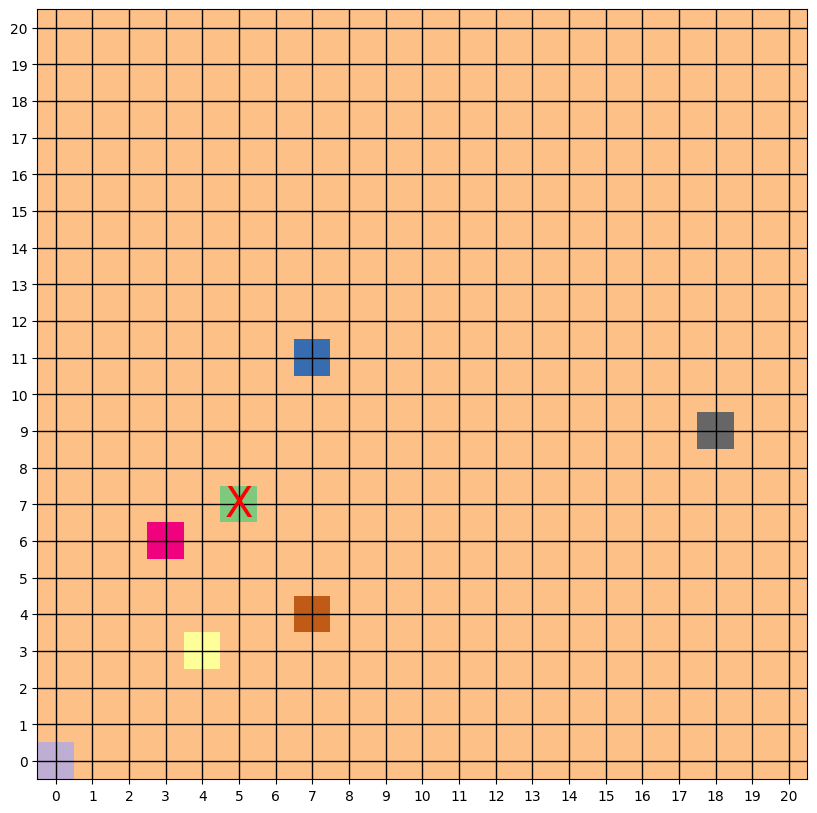

In [8]:
# Display the numerical version of the updated grid
print("Updated grid:")
print(grid_result)
print("\n") 
print("\n")



fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(grid_result, cmap='Accent', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])


# Add grid lines for better visualization (optional)
plt.grid(True, which='both', color='black', linewidth=1)


# Set axis ticks and labels in the center of squares
plt.xticks(np.arange(0.5, grid_size[0] + 0.5, 1), np.arange(0, grid_size[0], 1))
plt.yticks(np.arange(0.5, grid_size[1] + 0.5, 1), np.arange(0, grid_size[1], 1))



# Display the red cross on the plot
plt.text(red_cross_position[1] + 0.5, red_cross_position[0] + 0.5, 'X', fontsize=30, color='r', ha='center', va='center')

# Show the plot in a pop-up window
plt.show(block=True)

## **Monte Carlo Simulation**

In [9]:
number_of_steps_needed_to_approach_the_target = []
number_of_steps_needed_to_transmit_target_position_to_CC = []



for rep in range (10000):
    
    def place_robots(num_robots, specified_positions=None, grid_size=(21, 21)):
    
    
        grid = np.full(grid_size, None, dtype=object)


        grid[0, 0] = -1  


        if specified_positions is not None and len(specified_positions) == num_robots:
            robot_positions = specified_positions
        else:
            all_positions = np.array(np.meshgrid(range(1, grid_size[0]), range(1, grid_size[1]))).T.reshape(-1, 2)

            robot_positions = all_positions[np.random.choice(len(all_positions), size=num_robots, replace=False)]


        robot_names = np.arange(1, num_robots + 1)



        for position, name in zip(robot_positions, robot_names):
            grid[position[0], position[1]] = name


        while True:
            red_cross_position = np.random.choice(range(1, grid_size[0]), size=2)
            if grid[red_cross_position[0], red_cross_position[1]] is None:
                break

        grid_numeric = np.zeros_like(grid, dtype=int)
        grid_numeric[grid == -1] = -1  


        for i in range(1, num_robots + 1):
            grid_numeric[grid == i] = i


        grid_numeric[red_cross_position[0], red_cross_position[1]] = -2

        return grid_numeric, red_cross_position, grid_size


    specified_positions = []
    num_robots = 5


    grid_result, red_cross_position, grid_size = place_robots(num_robots, specified_positions, grid_size=(21, 21))

    
    
    
    
    pos_init = []
    current_positions = None
    
    for robot in range(1, num_robots + 1):
        pos_init.append(np.argwhere(grid_result == robot)[0])
    current_positions = [pos_init[robot][::-1] for robot in range(num_robots)]
    
    
    
    
    directions = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0)}
    moves = ["up", "down", "left", "right"]

    


    def get_possible_moves(pos, grid_size, occupied_positions):
        max_x, max_y = grid_size
        x, y = pos
        possible_moves = []
        
        for move in moves:
            new_x, new_y = x + directions[move][0], y + directions[move][1]
            if 1 <= new_x < max_x and 1 <= new_y < max_y :
                if not any(np.array_equal(pair, (new_x, new_y)) for pair in occupied_positions) :
                    possible_moves.append(move)

        return possible_moves



    occupied_positions = None
    occupied_positions = {tuple(pair) for pair in current_positions}
    occupied_positions.add(tuple(red_cross_position[::-1]))



    t = 0
    target_reached = False

    while not target_reached :

        t += 1
        new_positions = []
        found_by = np.zeros(num_robots)

        for robot in range(num_robots):
            
            current_pos = None
            current_pos = current_positions[robot]
            
            move_choices = None
            move_choices = get_possible_moves(current_pos, grid_size, occupied_positions)


            if move_choices:
                
                new_position = None
                new_position = tuple(np.add(current_pos, directions[random.choice(move_choices)]))

                new_positions.append(np.array(new_position))

                current_positions[robot] = np.array(new_position)

                grid_result[current_pos[1], current_pos[0]] = 0
                grid_result[new_positions[robot][1], new_positions[robot][0]] = robot + 1


                occupied_positions.remove(tuple(current_pos))

                occupied_positions.add(new_position)

            else:

                new_positions.append(current_pos)
                current_positions[robot] = current_pos


        for robot in range(num_robots):
            if math.sqrt((new_positions[robot][0] - red_cross_position[1]) ** 2 + (new_positions[robot][1] - red_cross_position[0]) ** 2) <= detection_range:
                target_reached = True
                found_by[robot] = 1

            else:
                found_by[robot] = 0
                
        if target_reached == True :
            number_of_steps_needed_to_approach_the_target.append(t)
        else : 
            pass



    found_by_ar = np.array(found_by)
    non_null_position = np.nonzero(found_by_ar)[0][0]
    target_perimeter = new_positions[non_null_position]
    
    
    current_positions2 = None
    current_positions2 = new_positions



    CC_reached = False




    # Is the robot that found the target within transmission range of the CC ??
    if (math.sqrt((current_positions2[non_null_position][0] - 0) ** 2 +
                  (current_positions2[non_null_position][1] - 0) ** 2) <= transmission_range):
        CC_reached = True
        number_of_steps_needed_to_transmit_target_position_to_CC.append(0)




    prox = np.zeros(num_robots)
    exit = False

    if CC_reached == False:

        for robot in range(num_robots):

            # Is there a robot close to the robot that found the target and that is closer to the command center ? 
            if 0 < (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 
                                    + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) <= transmission_range :

                prox[robot] = 1


            elif (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 
                                    + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) == 0 : 
                prox[robot] = None 

            else : 
                prox[robot] = 0


        ind = np.where(np.array(prox) == 1)[0]



        if len(ind) == 0 :
            pass

        else : 
            dist_to_CC = np.zeros(num_robots)

            cand = []


            for robot in range(num_robots) :

                if robot in ind : 

                    dist_to_CC[robot] = math.sqrt( (current_positions2[robot][0] - 0)**2 + 
                                              (current_positions2[robot][1] - 0)**2 )

                    if 0 < dist_to_CC[robot] <= transmission_range : 
                        CC_reached = True


                    if (dist_to_CC[robot] > transmission_range) and (dist_to_CC[robot] < math.sqrt( (current_positions2[non_null_position][0] - 0)**2 + 
                                                                                                   (current_positions2[non_null_position ][1] - 0)**2 ) ): 
                        cand.append(robot)

                else : 
                    dist_to_CC[robot] = 10000



            if CC_reached == True : 
                number_of_steps_needed_to_transmit_target_position_to_CC.append(0)
                exit = True


            if not exit : 
                if len(cand) == 0 : 
                    pass


                else : 

                    relay1 = None
                    relay1 = np.argmin(dist_to_CC)


                    # Is there a direct 2nd relay ?
                    potential_direct_2nd_relay = []
                    potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                  0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                  np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                    if len(potential_direct_2nd_relay) != 0 :  
                        direct_relay2 = None
                        direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                        CC_reached = True
                        number_of_steps_needed_to_transmit_target_position_to_CC.append(0)

                    else : 

                        # Is there an indirect 2nd relay
                        potential_indirect_2nd_relay = []
                        potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                        0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                        np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                        # Indirect 2nd relay in the sector
                        if len(potential_indirect_2nd_relay) != 0 :
                            indirect_relay2 = None
                            indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))


                            p_relay2 = 0

                            while not CC_reached : 

                                p_relay2 += 1
                                new_positions2 = []
                                sent_by = np.zeros(num_robots)


                                for robot in range(num_robots):


                                    current_pos2 = None
                                    current_pos2 = current_positions2[robot]

                                    if robot == indirect_relay2 :

                                        best_move_found = False

                                        len_to_CC = []
                                        len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                        sorted_moves = None
                                        sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                        move = None
                                        for move in sorted_moves : 

                                            new_position2 = None
                                            new_position2 = tuple(np.add(current_pos2, directions[move]))

                                            if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                new_positions2.append(np.array(new_position2))
                                                current_positions2[robot] = np.array(new_position2)

                                                best_move_found = True

                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                occupied_positions.remove(tuple(current_pos2))
                                                occupied_positions.add(new_position2)

                                                break

                                        if not best_move_found : 

                                            current_positions2[robot] = current_pos2
                                            new_positions2.append(current_pos2)



                                    else : 

                                        move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                        if move_choices :
                                            new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                            new_positions2.append(np.array(new_position2))


                                            current_positions2[robot] = np.array(new_position2)

                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                            grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                            occupied_positions.remove(tuple(current_pos2))
                                            occupied_positions.add(new_position2)


                                        else:

                                            new_positions2.append(current_pos2)
                                            current_positions2[robot] = current_pos2



                                if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                    sent_by[indirect_relay2] = 1
                                    CC_reached = True
                                    number_of_steps_needed_to_transmit_target_position_to_CC.append(p_relay2)

                                else:
                                    sent_by[indirect_relay2] = 0



                        # No indirect 2nd relay in the sector
                        else : 

                            p_relay1 = 0

                            while not CC_reached : 

                                p_relay1 += 1
                                new_positions2 = []
                                sent_by = np.zeros(num_robots)


                                for robot in range(num_robots):


                                    current_pos2 = None
                                    current_pos2 = current_positions2[robot]


                                    if robot == relay1 :

                                        best_move_found = False

                                        len_to_CC = []
                                        len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                        sorted_moves = None
                                        sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                        move = None
                                        for move in sorted_moves : 

                                            new_position2 = None
                                            new_position2 = tuple(np.add(current_pos2, directions[move]))

                                            if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                new_positions2.append(np.array(new_position2))
                                                current_positions2[robot] = np.array(new_position2)

                                                best_move_found = True

                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                occupied_positions.remove(tuple(current_pos2))
                                                occupied_positions.add(new_position2)

                                                break

                                        if not best_move_found : 

                                            current_positions2[robot] = current_pos2
                                            new_positions2.append(current_pos2)



                                    else : 

                                        move_choices = None
                                        move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                        if move_choices :
                                            new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                            new_positions2.append(np.array(new_position2))

                                            current_positions2[robot] = np.array(new_position2)

                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                            grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                            occupied_positions.remove(tuple(current_pos2))
                                            occupied_positions.add(new_position2)


                                        else:

                                            new_positions2.append(current_pos2)
                                            current_positions2[robot] = current_pos2




                                if (math.sqrt((new_positions2[relay1][0] - 0) ** 2 + 
                                              (new_positions2[relay1][1] - 0) ** 2) <= transmission_range):
                                    sent_by[relay1] = 1
                                    CC_reached = True
                                    number_of_steps_needed_to_transmit_target_position_to_CC.append(p_relay1)

                                else:
                                    sent_by[relay1] = 0


                                    # Is there a direct 2nd relay ?
                                    potential_direct_2nd_relay = []
                                    potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                  0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                  np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                                    if len(potential_direct_2nd_relay) != 0 :  
                                        direct_relay2 = None
                                        direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                                        CC_reached = True
                                        number_of_steps_needed_to_transmit_target_position_to_CC.append(p_relay1)

                                    else : 

                                        # Is there an indirect 2nd relay
                                        potential_indirect_2nd_relay = []
                                        potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                        0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                        np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                                        # Indirect 2nd relay in the sector
                                        if len(potential_indirect_2nd_relay) != 0 :
                                            indirect_relay2 = None
                                            indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))

                                            p_relay2 = 0


                                            while not CC_reached : 

                                                p_relay2 += 1
                                                new_positions2 = []
                                                sent_by = np.zeros(num_robots)



                                                for robot in range(num_robots):


                                                    current_pos2 = None
                                                    current_pos2 = current_positions2[robot]


                                                    if robot == indirect_relay2 :

                                                        best_move_found = False

                                                        len_to_CC = []
                                                        len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                                        sorted_moves = None
                                                        sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                                        move = None
                                                        for move in sorted_moves : 

                                                            new_position2 = None
                                                            new_position2 = tuple(np.add(current_pos2, directions[move]))

                                                            if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                                new_positions2.append(np.array(new_position2))
                                                                current_positions2[robot] = np.array(new_position2)

                                                                best_move_found = True


                                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                                grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                                occupied_positions.remove(tuple(current_pos2))
                                                                occupied_positions.add(new_position2)


                                                                break

                                                        if not best_move_found : 

                                                            current_positions2[robot] = current_pos2
                                                            new_positions2.append(current_pos2)


                                                    else : 

                                                        move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                                        if move_choices :
                                                            new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                                            new_positions2.append(np.array(new_position2))

                                                            current_positions2[robot] = np.array(new_position2)

                                                            grid_result[current_pos2[1], current_pos2[0]] = 0
                                                            grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                                            occupied_positions.remove(tuple(current_pos2))
                                                            occupied_positions.add(new_position2)


                                                        else:

                                                            new_positions2.append(current_pos2)
                                                            current_positions2[robot] = current_pos2



                                                if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + 
                                                              (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                                    sent_by[indirect_relay2] = 1
                                                    CC_reached = True
                                                    number_of_steps_needed_to_transmit_target_position_to_CC.append(p_relay1 + p_relay2)

                                                else:
                                                    sent_by[indirect_relay2] = 0



                                        else :
                                            pass




    k = 0  

    exit2 = False
    while not CC_reached : 


        new_positions2 = []
        sent_by = np.zeros(num_robots)
        k += 1

        for robot in range(num_robots):        

            current_pos2 = None
            current_pos2 = current_positions2[robot]

            if robot == non_null_position :

                best_move_found = False

                len_to_CC = []
                len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                sorted_moves = None
                sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                move = None
                for move in sorted_moves : 

                    new_position2 = None
                    new_position2 = tuple(np.add(current_pos2, directions[move]))

                    if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                        new_positions2.append(np.array(new_position2))
                        current_positions2[robot] = np.array(new_position2)

                        best_move_found = True

                        grid_result[current_pos2[1], current_pos2[0]] = 0
                        grid_result[new_position2[1], new_position2[0]] = robot + 1

                        occupied_positions.remove(tuple(current_pos2))
                        occupied_positions.add(new_position2)

                        break

                if not best_move_found : 

                    current_positions2[robot] = current_pos2
                    new_positions2.append(current_pos2)



            else : 

                move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                if move_choices :
                    new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                    new_positions2.append(np.array(new_position2))

                    current_positions2[robot] = np.array(new_position2)

                    grid_result[current_pos2[1], current_pos2[0]] = 0
                    grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                    occupied_positions.remove(tuple(current_pos2))
                    occupied_positions.add(new_position2)


                else:

                    new_positions2.append(current_pos2)
                    current_positions2[robot] = current_pos2



        if (math.sqrt((new_positions2[non_null_position][0] - 0) ** 2 + 
                      (new_positions2[non_null_position][0] - 0) ** 2) <= transmission_range) : 
            CC_reached = True
            number_of_steps_needed_to_transmit_target_position_to_CC.append(k)
            break


        prox = np.zeros(num_robots)

        if CC_reached == False:

            for robot in range(num_robots):

                # Is there a robot close to the robot that found the target and that is closer to the command center ? 
                if 0 < (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 
                                        + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) <= transmission_range :

                    prox[robot] = 1


                elif (math.sqrt((current_positions2[robot][0] - current_positions2[non_null_position][0])**2 
                                        + (current_positions2[robot][1] - current_positions2[non_null_position][1])**2)) == 0 : 
                    prox[robot] = None 

                else : 
                    prox[robot] = 0


            ind = np.where(np.array(prox) == 1)[0]



            if len(ind) == 0 :
                pass

            else : 
                dist_to_CC = np.zeros(num_robots)

                cand = []


                for robot in range(num_robots) :

                    if robot in ind : 

                        dist_to_CC[robot] = math.sqrt( (current_positions2[robot][0] - 0)**2 + 
                                                  (current_positions2[robot][1] - 0)**2 )

                        if 0 < dist_to_CC[robot] <= transmission_range : 
                            CC_reached = True


                        if (dist_to_CC[robot] > transmission_range) and (dist_to_CC[robot] < math.sqrt( (current_positions2[non_null_position][0] - 0)**2 + 
                                                                                                       (current_positions2[non_null_position ][1] - 0)**2 ) ): 
                            cand.append(robot)


                    else : 
                        dist_to_CC[robot] = 10000



                if CC_reached == True : 
                    number_of_steps_needed_to_transmit_target_position_to_CC.append(k)
                    exit2 = True


                if not exit2 : 


                    if len(cand) == 0 : 
                        pass

                    else : 

                        relay1 = None
                        relay1 = np.argmin(dist_to_CC)


                        # Is there a direct 2nd relay ?
                        potential_direct_2nd_relay = []
                        potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                      0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                      np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                        if len(potential_direct_2nd_relay) != 0 :  
                            direct_relay2 = None
                            direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                            CC_reached = True
                            number_of_steps_needed_to_transmit_target_position_to_CC.append(k)

                        else : 



                            # Is there an indirect 2nd relay
                            potential_indirect_2nd_relay = []
                            potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                            0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                            np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                            # Indirect 2nd relay in the sector
                            if len(potential_indirect_2nd_relay) != 0 :
                                indirect_relay2 = None
                                indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))


                                p_relay2 = 0

                                while not CC_reached : 

                                    p_relay2 += 1
                                    new_positions2 = []
                                    sent_by = np.zeros(num_robots)


                                    for robot in range(num_robots):

                                        current_pos2 = None
                                        current_pos2 = current_positions2[robot]

                                        if robot == indirect_relay2 :

                                            best_move_found = False

                                            len_to_CC = []
                                            len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                            sorted_moves = None
                                            sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                            move = None
                                            for move in sorted_moves : 

                                                new_position2 = None
                                                new_position2 = tuple(np.add(current_pos2, directions[move]))

                                                if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                    new_positions2.append(np.array(new_position2))
                                                    current_positions2[robot] = np.array(new_position2)

                                                    best_move_found = True


                                                    grid_result[current_pos2[1], current_pos2[0]] = 0
                                                    grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                    occupied_positions.remove(tuple(current_pos2))
                                                    occupied_positions.add(new_position2)


                                                    break

                                            if not best_move_found : 

                                                current_positions2[robot] = current_pos2
                                                new_positions2.append(current_pos2)



                                        else : 

                                            move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                            if move_choices :
                                                new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                                new_positions2.append(np.array(new_position2))

                                                current_positions2[robot] = np.array(new_position2)

                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                                occupied_positions.remove(tuple(current_pos2))
                                                occupied_positions.add(new_position2)

                                            else:

                                                new_positions2.append(current_pos2)
                                                current_positions2[robot] = current_pos2



                                    if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + 
                                                  (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                        sent_by[indirect_relay2] = 1
                                        CC_reached = True
                                        number_of_steps_needed_to_transmit_target_position_to_CC.append(k + p_relay2)

                                    else:
                                        sent_by[indirect_relay2] = 0 


                            # No indirect 2nd relay in the sector
                            else : 

                                p_relay1 = 0

                                while not CC_reached : 

                                    p_relay1 += 1
                                    new_positions2 = []
                                    sent_by = np.zeros(num_robots)


                                    for robot in range(num_robots):


                                        current_pos2 = None
                                        current_pos2 = current_positions2[robot]


                                        if robot == relay1 :

                                            best_move_found = False

                                            len_to_CC = []
                                            len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                            sorted_moves = None
                                            sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                            move = None
                                            for move in sorted_moves : 

                                                new_position2 = None
                                                new_position2 = tuple(np.add(current_pos2, directions[move]))

                                                if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                    new_positions2.append(np.array(new_position2))
                                                    current_positions2[robot] = np.array(new_position2)

                                                    best_move_found = True


                                                    grid_result[current_pos2[1], current_pos2[0]] = 0
                                                    grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                    occupied_positions.remove(tuple(current_pos2))
                                                    occupied_positions.add(new_position2)


                                                    break

                                            if not best_move_found : 

                                                current_positions2[robot] = current_pos2
                                                new_positions2.append(current_pos2)


                                        else : 

                                            move_choices = None
                                            move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                            if move_choices :
                                                new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                                new_positions2.append(np.array(new_position2))

                                                current_positions2[robot] = np.array(new_position2)

                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                                occupied_positions.remove(tuple(current_pos2))
                                                occupied_positions.add(new_position2)


                                            else:

                                                new_positions2.append(current_pos2)
                                                current_positions2[robot] = current_pos2




                                    if (math.sqrt((new_positions2[relay1][0] - 0) ** 2 + 
                                                  (new_positions2[relay1][1] - 0) ** 2) <= transmission_range):
                                        sent_by[relay1] = 1
                                        CC_reached = True
                                        number_of_steps_needed_to_transmit_target_position_to_CC.append(k + p_relay1)

                                    else:
                                        sent_by[relay1] = 0 


                                        # Is there a direct 2nd relay ?
                                        potential_direct_2nd_relay = []
                                        potential_direct_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                      0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                      np.linalg.norm(current_positions2[robot])  <= transmission_range ]


                                        if len(potential_direct_2nd_relay) != 0 :  
                                            direct_relay2 = min(potential_direct_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))
                                            CC_reached = True
                                            number_of_steps_needed_to_transmit_target_position_to_CC.append(k + p_relay1)


                                        else : 

                                            # Is there an indirect 2nd relay
                                            potential_indirect_2nd_relay = []
                                            potential_indirect_2nd_relay = [ robot for robot in range(num_robots) if robot != relay1 and robot != non_null_position and 
                                                                            0 < np.linalg.norm(current_positions2[robot] - current_positions2[relay1]) <= transmission_range and
                                                                            np.linalg.norm(current_positions2[robot])  < np.linalg.norm(current_positions2[relay1]) ]


                                            # Indirect 2nd relay in the sector
                                            if len(potential_indirect_2nd_relay) != 0 :
                                                indirect_relay2 = None
                                                indirect_relay2 = min(potential_indirect_2nd_relay, key=lambda relay: np.linalg.norm(current_positions2[relay] - [0, 0]))


                                                p_relay2 = 0


                                                while not CC_reached : 

                                                    p_relay2 += 1
                                                    new_positions2 = []
                                                    sent_by = np.zeros(num_robots)


                                                    for robot in range(num_robots):

                                                        current_pos2 = None
                                                        current_pos2 = current_positions2[robot]

                                                        if robot == indirect_relay2 :

                                                            best_move_found = False

                                                            len_to_CC = []
                                                            len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]


                                                            sorted_moves = None
                                                            sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]


                                                            move = None
                                                            for move in sorted_moves : 

                                                                new_position2 = None
                                                                new_position2 = tuple(np.add(current_pos2, directions[move]))

                                                                if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                                                                    new_positions2.append(np.array(new_position2))
                                                                    current_positions2[robot] = np.array(new_position2)

                                                                    best_move_found = True


                                                                    grid_result[current_pos2[1], current_pos2[0]] = 0
                                                                    grid_result[new_position2[1], new_position2[0]] = robot + 1

                                                                    occupied_positions.remove(tuple(current_pos2))
                                                                    occupied_positions.add(new_position2)

                                                                    break

                                                            if not best_move_found : 

                                                                current_positions2[robot] = current_pos2
                                                                new_positions2.append(current_pos2)


                                                        else : 

                                                            move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                                                            if move_choices :
                                                                new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                                                                new_positions2.append(np.array(new_position2))

                                                                current_positions2[robot] = np.array(new_position2)

                                                                grid_result[current_pos2[1], current_pos2[0]] = 0
                                                                grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                                                                occupied_positions.remove(tuple(current_pos2))
                                                                occupied_positions.add(new_position2)

                                                            else:

                                                                new_positions2.append(current_pos2)
                                                                current_positions2[robot] = current_pos2




                                                    if (math.sqrt((new_positions2[indirect_relay2][0] - 0) ** 2 + 
                                                                  (new_positions2[indirect_relay2][1] - 0) ** 2) <= transmission_range):
                                                        sent_by[indirect_relay2] = 1
                                                        CC_reached = True
                                                        number_of_steps_needed_to_transmit_target_position_to_CC.append(k + p_relay1 + p_relay2)

                                                    else:
                                                        sent_by[indirect_relay2] = 0 



                                            else :
                                                pass


avg_steps1 = np.mean(number_of_steps_needed_to_approach_the_target)
print("Average number of steps needed to find the target = ", avg_steps1)

avg_steps2 = np.mean(number_of_steps_needed_to_transmit_target_position_to_CC)
print("Average number of steps needed to transmit its position = ", avg_steps2)

Average number of steps needed to find the target =  83.8441
Average number of steps needed to transmit its position =  10.1969


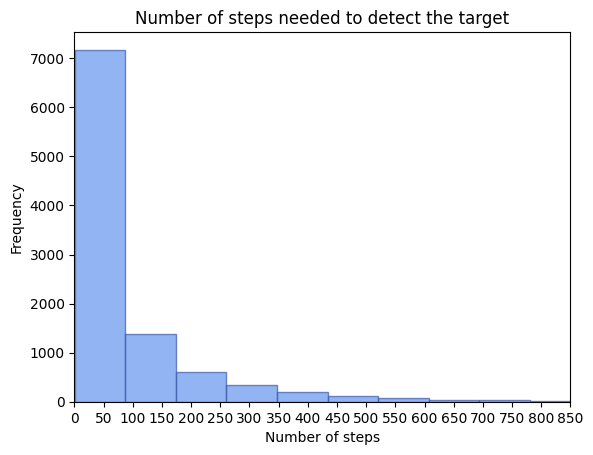

In [10]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(number_of_steps_needed_to_approach_the_target, 
                           bins=20, color="#6495ED", ec= "#3D59AB", alpha = 0.7)

ax.set_xlim([0, 850])

ech = np.arange(0, 851, 50)
etiquettes = [str(i) for i in ech]

ax.set_xticks(ech)
ax.set_xticklabels(etiquettes)

ax.set_title('Number of steps needed to detect the target')

ax.set_xlabel('Number of steps')
ax.set_ylabel('Frequency')

plt.show()

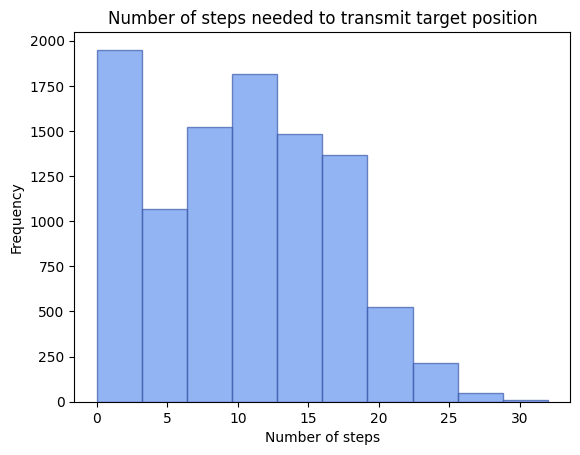

In [11]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(number_of_steps_needed_to_transmit_target_position_to_CC,
                           color="#6495ED", ec= "#3D59AB", alpha=0.7)

ax.set_title('Number of steps needed to transmit target position')

ax.set_xlabel('Number of steps')
ax.set_ylabel('Frequency')


plt.show()

#### These histograms above show the results obtained after 10 000 applications of this new strategy. Since the search strategy is the same as for the basic strategy, the distribution of the number of steps required to find the target is the same as previously seen. Instead, we will focus on how the possibility of having up to two relays has changed the distribution of the number of steps needed to transmit the target's position.            


#### We can see that the number of cases where the number of steps needed to report the target’s position is between 0 and 5 has significantly increased. Furthermore, the mode of this new distribution is 1, which means that in the most of cases of this simulation it took just 1 step to transmit the target’s position. Therefore, the possibility of having relays makes the transmission phase more efficient.

In [12]:
stats.mode(number_of_steps_needed_to_transmit_target_position_to_CC)

ModeResult(mode=1, count=1063)

In [13]:
most_common_values = Counter(number_of_steps_needed_to_transmit_target_position_to_CC).most_common(20)

# Print the result
for value, count in most_common_values:
    print(f"Value: {value}, Count: {count}")

Value: 1, Count: 1063
Value: 10, Count: 633
Value: 11, Count: 609
Value: 12, Count: 573
Value: 9, Count: 554
Value: 13, Count: 526
Value: 8, Count: 496
Value: 14, Count: 481
Value: 15, Count: 478
Value: 7, Count: 473
Value: 17, Count: 418
Value: 6, Count: 405
Value: 16, Count: 386
Value: 0, Count: 361
Value: 5, Count: 353
Value: 18, Count: 308
Value: 4, Count: 307
Value: 3, Count: 274
Value: 19, Count: 255
Value: 2, Count: 252
